# Notebook to learn tau (z) mapping in pytorch

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import torch


# Load and shape dataset:

In [3]:
def readsim(file):
    raw = np.loadtxt(file)
    return np.transpose(raw.reshape((64,252,252)))

In [4]:
sim_z = np.loadtxt('/Users/neku5162/Desktop/time_series/z_100.csv')

short_z = sim_z[4:40] # cut the atmosphere to the values where the line is sensitive

sim_tau = np.log10(readsim('/Users/neku5162/Desktop/time_series/tau_100.csv')[:,:,1:])
sim_tau = np.append(np.zeros((252,252,1))-6.0,sim_tau,axis=2) ## append log tau = -6 at the start

raw_spectra = np.transpose(np.loadtxt('spectrum.csv').reshape((257,252,252)))
spctr_cube = raw_spectra/np.mean(raw_spectra) # normalize spectra by mean intensity 

In [5]:
#define simulation parameters and chunk sizes
n_spec = 257
n_tau = 64
nx = 252
ny = 252
x_chunk = 28 
y_chunk = 28
n_chunks = int(nx*ny/(x_chunk*y_chunk))


def mk_training_chunks(size,samples):
    train_max = 200 # resevre remaing 50 x 50 cells for validation/testing
    spectra_train = np.zeros((samples, size, size, n_spec))
    tau_train = np.zeros((samples, size, size, n_tau))
    
    l = size/2
    for s in np.arange(samples):
        x_c = np.random.randint(size/2,train_max - size/2) # randomly pick x center
        y_c = np.random.randint(size/2,train_max - size/2) # randomly pick y center
        
        xlo = int(x_c-l)
        xhi = int(x_c+l)
        ylo = int(y_c-l)
        yhi = int(y_c+l)

        spectra_train[s] = spctr_cube[xlo:xhi, ylo:yhi, :]
        tau_train[s]     =    sim_tau[xlo:xhi, ylo:yhi, :]
    
    # Reshape arrays so it fits in pytorch convetions of (N, Channels, Height, Width)
    
    return np.transpose(spectra_train,(0,3,1,2)),np.transpose(tau_train,(0,3,1,2))
    

In [6]:
#Make training set
spectra_train, tau_train = mk_training_chunks(x_chunk,1000)

In [7]:
print(spectra_train.shape)
print(tau_train.shape)

(1000, 257, 28, 28)
(1000, 64, 28, 28)


# Define conv neural net 

In [8]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
import torch.nn.functional as F

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(257, 128, 5,padding=2)
        self.conv2 = nn.Conv2d(128, 64, 5,padding=2)
        self.conv3 = nn.Conv2d(64, 32, 5,padding=2)
        self.conv4 = nn.Conv2d(32, 64, 5,padding=2)
        self.conv5 = nn.Conv2d(64, 128, 5,padding=2)
        self.conv6 = nn.Conv2d(128, 256, 5,padding=2)
        self.conv7 = nn.Conv2d(256, 128, 5,padding=2)
        self.conv8 = nn.Conv2d(128, 64, 5,padding=2)



    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv7(x))
        x = self.conv8(x)
        return x


In [10]:
net = Net()
net = net.double()
optim = Adam(net.parameters())
L2 = nn.MSELoss()

### Make training and truth arrays:

In [11]:
trainingData = torch.from_numpy(spectra_train).type(torch.DoubleTensor)
trainingTruth = torch.from_numpy(tau_train).type(torch.DoubleTensor)
trainLoader = DataLoader(TensorDataset(trainingData, trainingTruth), batch_size=50, shuffle=True)

### Make validation data

In [12]:
#define simulation parameters and chunk sizes
n_spec = 257
n_tau = 64
nx = 252
ny = 252
x_chunk = 28 
y_chunk = 28
n_chunks = int(nx*ny/(x_chunk*y_chunk))


def mk_validation_chunks(samples,size):
    train_max = 200 # validate on remining cells (not the 200 x 200 patch we trained on)
    spectra_valid = np.zeros((samples, size, size, n_spec))
    tau_valid = np.zeros((samples, size, size, n_tau))
    
    l = size/2
    for s in np.arange(samples):
        x_c = np.random.randint(train_max + size/2,nx - size/2) # randomly pick x center
        y_c = np.random.randint(train_max + size/2,ny - size/2) # randomly pick y center
        
        xlo = int(x_c-l)
        xhi = int(x_c+l)
        ylo = int(y_c-l)
        yhi = int(y_c+l)

        spectra_valid[s] = spctr_cube[xlo:xhi, ylo:yhi, :]
        tau_valid[s]     =    sim_tau[xlo:xhi, ylo:yhi, :]
    
    return np.transpose(spectra_valid,(0,3,1,2)),np.transpose(tau_valid,(0,3,1,2))
    

In [13]:
spectra_valid,tau_valid = mk_validation_chunks(20,28)

In [14]:
print(spectra_valid.shape)
print(tau_valid.shape)

(20, 257, 28, 28)
(20, 64, 28, 28)


# Start training 

In [15]:
import time

In [16]:
net = torch.load('conv_5x5.pt')
#optim = Adam(net.parameters(),lr=1e-3)

In [167]:
num_epochs = 80
#training_loss = []
#validation_loss = []

for e in np.arange(num_epochs):
    
    if (e+5)%20 == 0:  # save the model every 40 epochs
        torch.save(net, 'torch_nn.pt')
        np.savetxt('validation_mse.txt', validation_loss)
        np.savetxt('training_loss.txt', training_loss)
    
    print("------------- epoch "+str(e)+" -------------")
    start_time = time.time()
    epoch_loss = 0.0
    for x, y in trainLoader:
        optim.zero_grad() # zero gradients 
        yhat = net(x)
        loss = L2(yhat, y)
        loss.backward()
        optim.step()
        epoch_loss += loss

    training_loss.append(epoch_loss.detach().numpy())
    
    validation_outputs = net(torch.from_numpy(spectra_valid)).detach().numpy() # torch tensor <-> numpy array
    valid_error = np.mean((validation_outputs - tau_valid)**2)
    validation_loss.append(valid_error)
    
    print("training loss: " + str(epoch_loss.detach().numpy()))
    print("validation loss: " + str(valid_error))
    print("time: "+ str(time.time() - start_time))
    print("\n")

    
torch.save(net, 'torch_nn.pt')
np.savetxt('validation_mse.txt', validation_loss)
np.savetxt('training_loss.txt', training_loss)


------------- epoch 0 -------------
training loss: 37.91531648216463
validation loss: 0.3928452282475793
time: 510.9686191082001


------------- epoch 1 -------------
training loss: 6.741276924024425
validation loss: 0.2549089715367845
time: 652.0667269229889


------------- epoch 2 -------------
training loss: 5.047580915252352
validation loss: 0.21858437679840412
time: 442.1620008945465


------------- epoch 3 -------------
training loss: 4.817563983241106
validation loss: 0.18086676775824556
time: 407.3612480163574


------------- epoch 4 -------------
training loss: 3.9355562119264684
validation loss: 0.15653819488806148
time: 325.82743883132935


------------- epoch 5 -------------
training loss: 3.3718881249212687
validation loss: 0.10009928268205269
time: 332.4154529571533


------------- epoch 6 -------------
training loss: 3.7638265994010873
validation loss: 0.1331494469903558
time: 330.09116220474243


------------- epoch 7 -------------
training loss: 3.1204712873938547
vali

training loss: 1.6447276601702245
validation loss: 0.08315158467159328
time: 396.90233516693115


------------- epoch 63 -------------
training loss: 1.6481168459424755
validation loss: 0.08511837070994065
time: 397.4040758609772


------------- epoch 64 -------------
training loss: 1.6593465273247405
validation loss: 0.06324862921891714
time: 396.71195912361145


------------- epoch 65 -------------
training loss: 1.5115076471522613
validation loss: 0.06216611955788542
time: 396.0425763130188


------------- epoch 66 -------------
training loss: 1.6275387292430155
validation loss: 0.05935619027906071
time: 396.35236501693726


------------- epoch 67 -------------
training loss: 1.5094372625992234
validation loss: 0.07646018464769008
time: 396.10157203674316


------------- epoch 68 -------------
training loss: 1.6756786241776052
validation loss: 0.08873189027301617
time: 396.13615894317627


------------- epoch 69 -------------
training loss: 1.565865084868899
validation loss: 0.05778

In [19]:
net = Net()
net = torch.load('conv_5x5.pt')

In [20]:
#plt.plot(range(200),np.array(training_loss),label = 'training loss')
plt.semilogy(range(80),np.array(validation_loss), label = 'validation MSE')
plt.legend()
plt.show()

NameError: name 'validation_loss' is not defined

In [21]:
model_parameters = filter(lambda p: p.requires_grad, net.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])

In [22]:
params

3178464

# Performance on validation set

In [23]:
validation_out =  net(torch.from_numpy(spectra_valid)).detach().numpy()
validation_truth = tau_valid

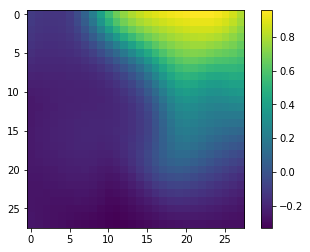

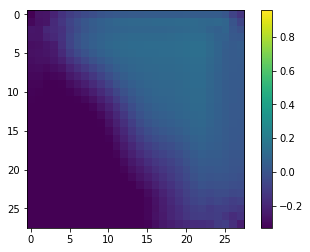

In [24]:
k = 24
n = 10
true = validation_truth[n,k,:,:]
pred = validation_out[n,k,:,:]

plt.imshow(true)
plt.colorbar()
lo = np.min(true)
hi = np.max(true)
plt.clim(lo,hi)
plt.show()
plt.imshow(pred)
plt.clim(lo,hi)
plt.colorbar()
plt.show()


In [25]:
validation_out =  net(torch.from_numpy(spectra_valid)).detach().numpy()
validation_truth = tau_valid

In [26]:
full_image = np.array([spctr_cube.transpose(2,0,1)])

In [27]:
full_image.shape

(1, 257, 252, 252)

In [28]:
validation_out =  net(torch.from_numpy(full_image)).detach().numpy()[0]
validation_out = validation_out.transpose(1,2,0)

In [29]:
validation_out.shape

(252, 252, 64)

In [30]:
noisy_input = full_image + np.random.normal(loc=0.0, scale=0.2, size=(1,n_spec,nx,ny))

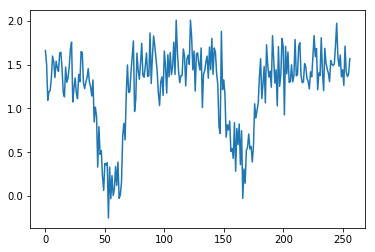

In [31]:
i = np.random.randint(nx)
j = np.random.randint(ny)
plt.plot(noisy_input[0,:,i,j])

In [32]:
noisy_validation_out =  net(torch.from_numpy(noisy_input)).detach().numpy()[0]
noisy_validation_out = noisy_validation_out.transpose(1,2,0)

In [33]:
!pwd

/Users/neku5162/Desktop/sir_inversions/2_line_run


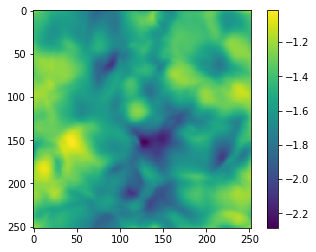

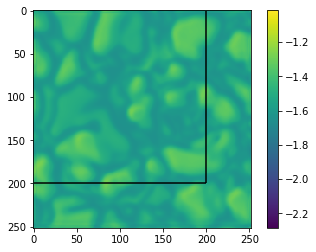

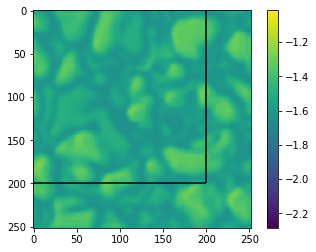

In [34]:
k = 13
true = sim_tau[:,:,k]
pred = validation_out[:,:,k]
noisy = noisy_validation_out[:,:,k]


plt.imshow(true)
plt.colorbar()
lo = np.min(true)
hi = np.max(true)
plt.show()


plt.imshow(pred)
plt.colorbar()
lo = np.min(true)
hi = np.max(true)
plt.clim(lo,hi)
plt.vlines(200,0,200)
plt.hlines(200,0,200)

plt.show()


plt.imshow(noisy)
plt.colorbar()
lo = np.min(true)
hi = np.max(true)
plt.clim(lo,hi)
plt.vlines(200,0,200)
plt.hlines(200,0,200)

plt.show()





In [35]:
#define simulation parameters and chunk sizes
n_spec = 257
n_tau = 64
nx = 252
ny = 252
x_chunk = 28 
y_chunk = 28
n_chunks = int(nx*ny/(x_chunk*y_chunk))


def mk_validation_chunks(samples,size):
    train_max = 200 # validate on remining cells (not the 200 x 200 patch we trained on)
    spectra_valid = np.zeros((samples, size, size, n_spec))
    tau_valid = np.zeros((samples, size, size, n_tau))
    
    l = size/2
    for s in np.arange(samples):
        x_c = np.random.randint(train_max + size/2,nx - size/2) # randomly pick x center
        y_c = np.random.randint(train_max + size/2,ny - size/2) # randomly pick y center
        
        xlo = int(x_c-l)
        xhi = int(x_c+l)
        ylo = int(y_c-l)
        yhi = int(y_c+l)

        spectra_valid[s] = spctr_cube[xlo:xhi, ylo:yhi, :]
        tau_valid[s]     =    sim_tau[xlo:xhi, ylo:yhi, :]
    
    return np.transpose(spectra_valid,(0,3,1,2)),np.transpose(tau_valid,(0,3,1,2))
    

In [36]:
spectra_valid,tau_valid = mk_validation_chunks(100,28)

In [37]:
validation_outputs = net(torch.from_numpy(spectra_valid))

In [38]:
validation_outputs.shape

torch.Size([100, 64, 28, 28])

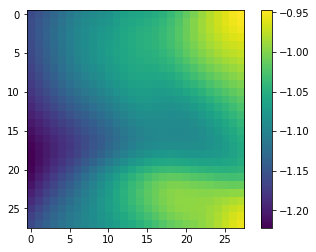

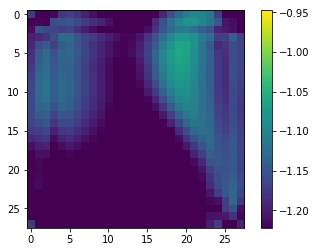

In [39]:
k = 15
n = 50
true = tau_valid[n,k]
pred = validation_outputs[n,k,:,:].detach().numpy()

plt.imshow(true)
plt.colorbar()
lo = np.min(true)
hi = np.max(true)
plt.clim(lo,hi)
plt.show()
plt.imshow(pred)
plt.clim(lo,hi)
plt.colorbar()
plt.show()
